## Import the main libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import joblib
import missingno

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor


from xgboost import XGBRegressor

## Load the dataset and look at the big picture

In [2]:
# import the dataset file
FILE_PATH = os.path.join(os.getcwd(), 'housing.csv')
df_housing = pd.read_csv(FILE_PATH)
df_housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [3]:
# check the data types 
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
# statistics about data
df_housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [5]:
# check null (pandas)
df_housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

<AxesSubplot: >

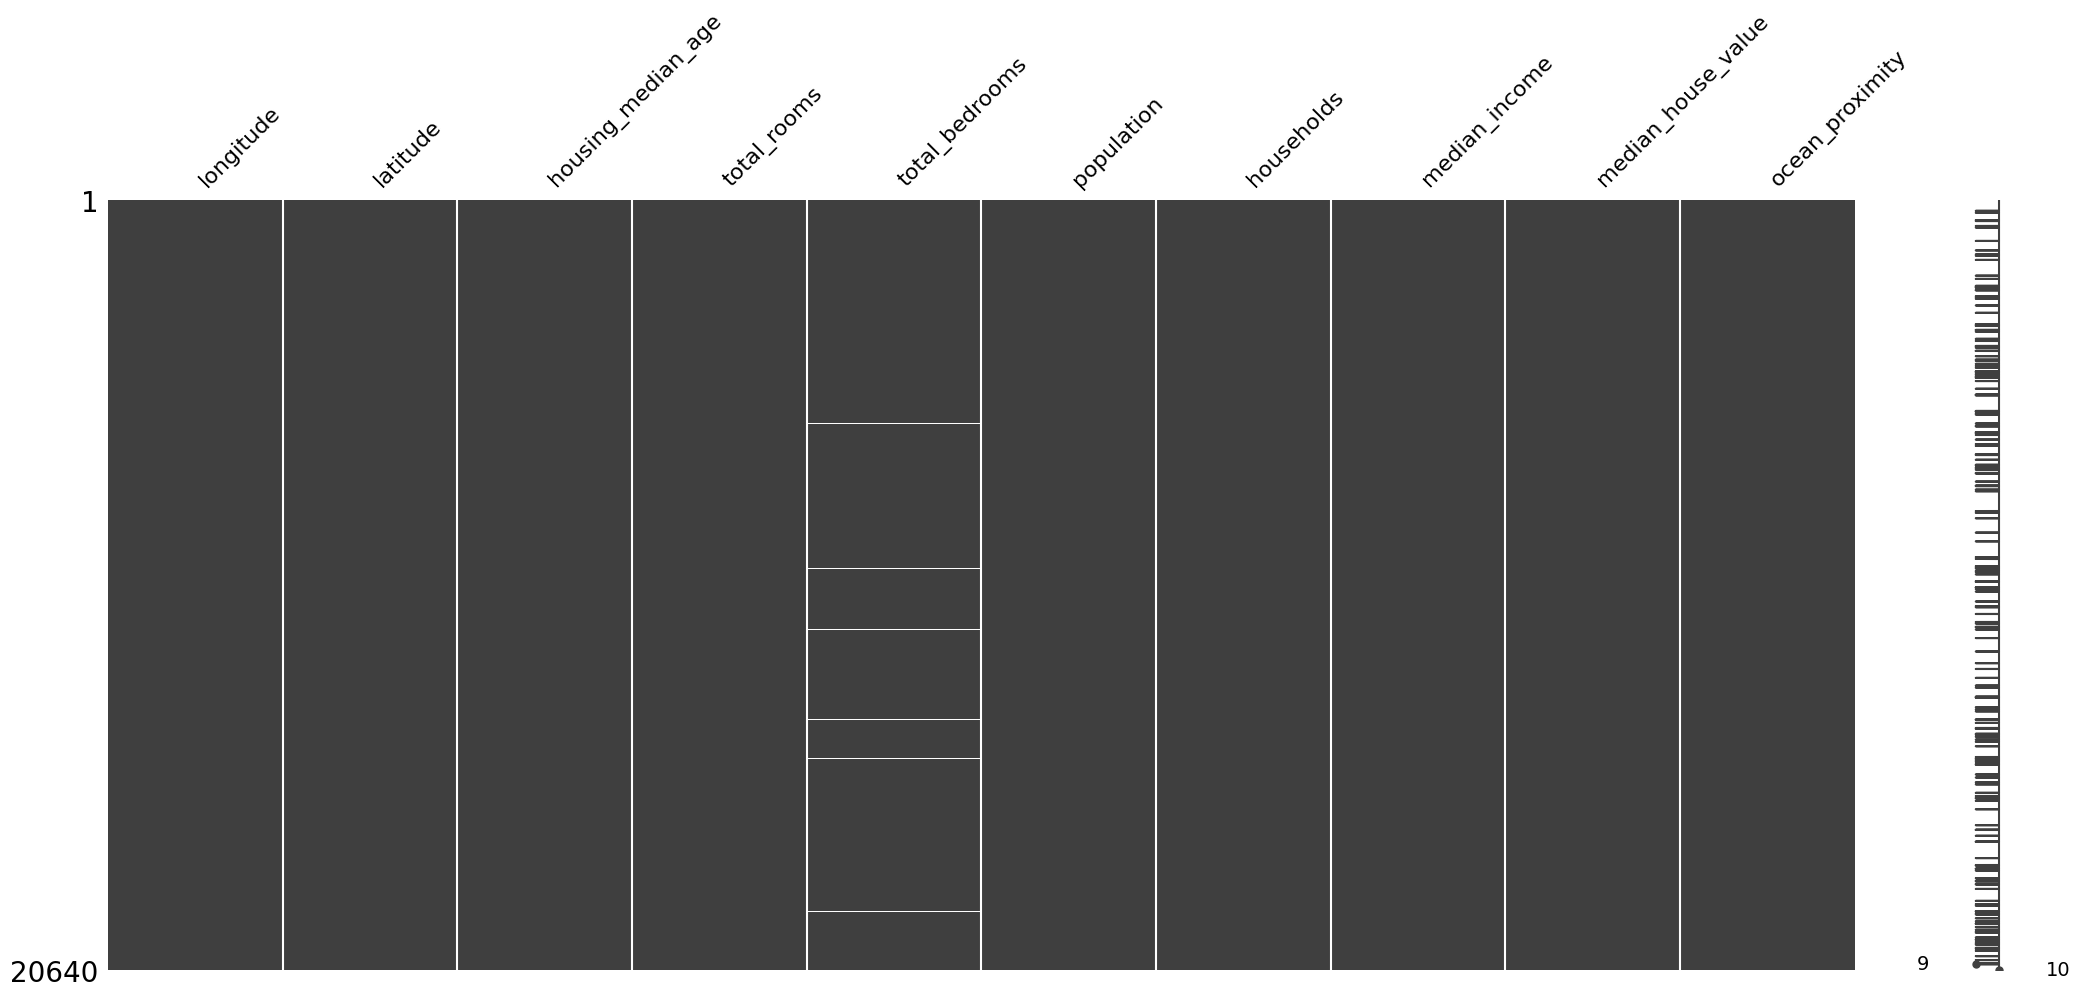

In [6]:
# check null (missingno)
missingno.matrix(df_housing)

> 'It looks like we have 207 null values in total_bedrooms feature.'

## Exploratory Data Analysis

### Univariate Visualization

In [7]:
ocean_values = df_housing['ocean_proximity'].unique()
ocean_values

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [8]:
# replace the (<1H OCEAN) with (1H OCEAN)
df_housing['ocean_proximity'].replace('<1H OCEAN', '1H OCEAN', inplace=True)

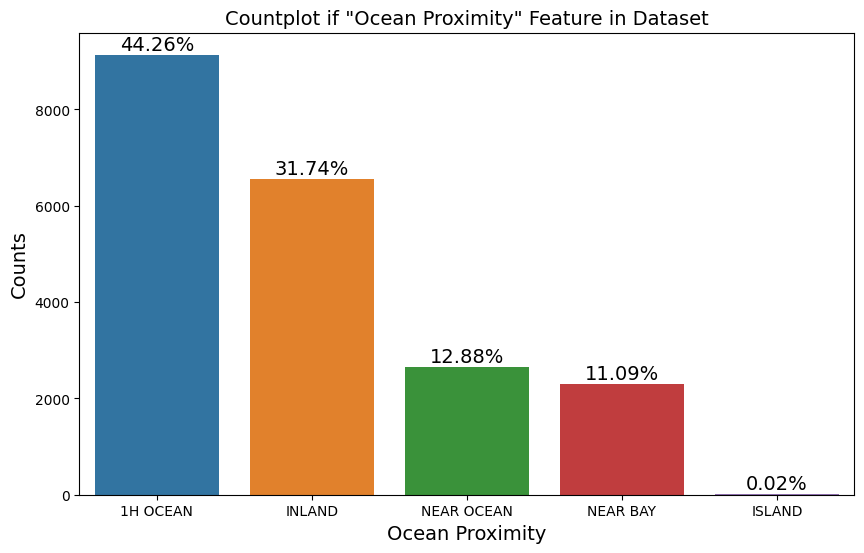

In [9]:
# Plot the ocean_values

replicates = df_housing['ocean_proximity'].value_counts()

plt.figure(figsize=(10, 6))
sns.countplot(x='ocean_proximity', data=df_housing, order=replicates.index)
plt.title('Countplot if "Ocean Proximity" Feature in Dataset', fontsize=14)
plt.xlabel('Ocean Proximity', fontsize=14)
plt.ylabel('Counts', fontsize=14)
for i in range(len(replicates)):
    each_count = replicates.values[i]
    each_text = f'{each_count*100/len(df_housing):.2f}%'
    plt.text(x=i, y= each_count + 100, s=each_text, ha='center', fontsize=14)
plt.show()

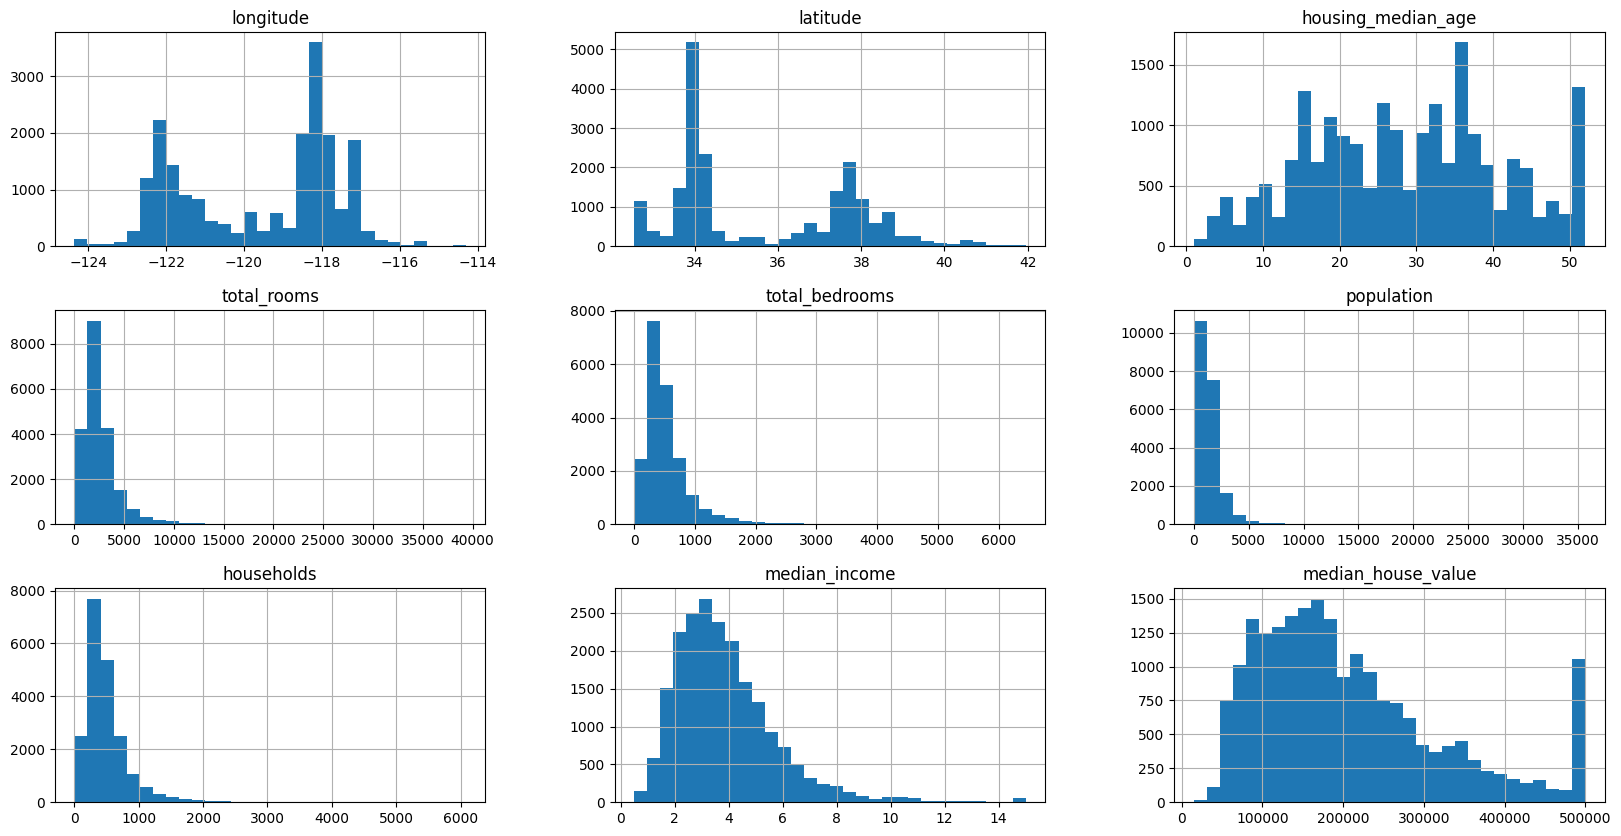

In [10]:
# numbers distribution of numerical features
df_housing.hist(bins=30, figsize=(20, 10))
plt.show()

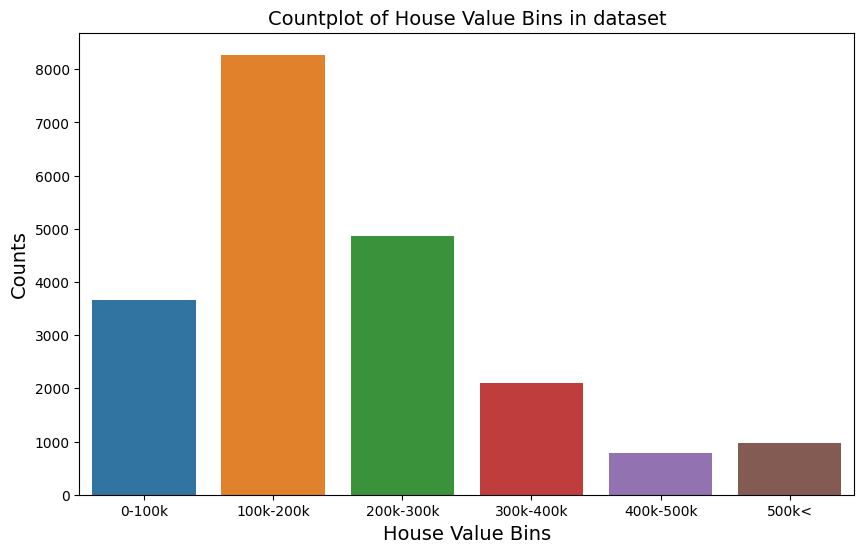

In [11]:
# Classify each house into category (Bins) based on 'median_house_value'
house_value_bins = pd.cut(x=df_housing['median_house_value'],
       bins=[-np.inf, 100000, 200000, 300000, 400000, 500000, np.inf],
      labels=['0-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k', '500k<'])

plt.figure(figsize=(10,6))
sns.countplot(x=house_value_bins)
plt.title('Countplot of House Value Bins in dataset', fontsize=14)
plt.xlabel('House Value Bins', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

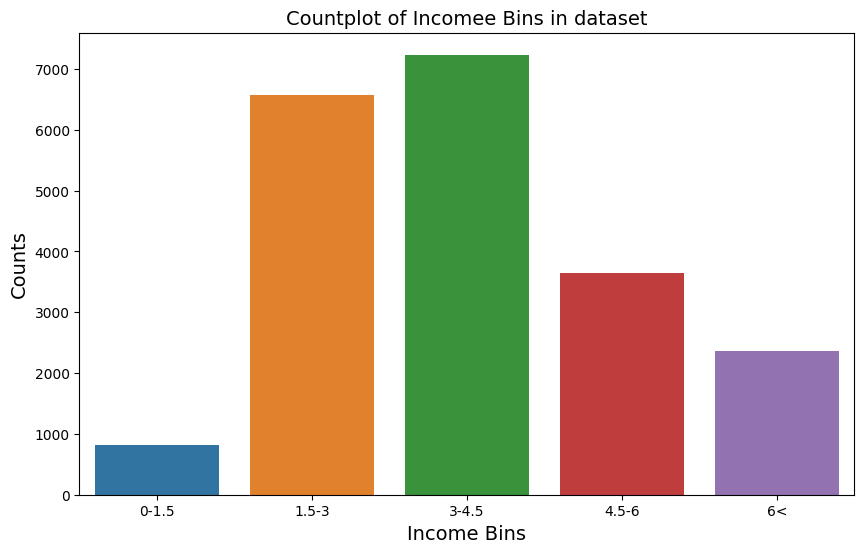

In [12]:
# Classify each house into category (Bins) based on 'median_income'
income_bins = pd.cut(x=df_housing['median_income'],
       bins=[-np.inf, 1.5, 3, 4.5, 6, np.inf],
      labels=['0-1.5', '1.5-3', '3-4.5', '4.5-6', '6<'])

plt.figure(figsize=(10,6))
sns.countplot(x=income_bins)
plt.title('Countplot of Incomee Bins in dataset', fontsize=14)
plt.xlabel('Income Bins', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.show()

> We can see that the majority of median_house is with 100K-200K, aslo with 1.5-4.5 in median_income, and half of the data are with 1H OCEAN in ocean_proximity, so we can't divide our data in random way

### Bivariate Visualization

<Figure size 1000x600 with 0 Axes>

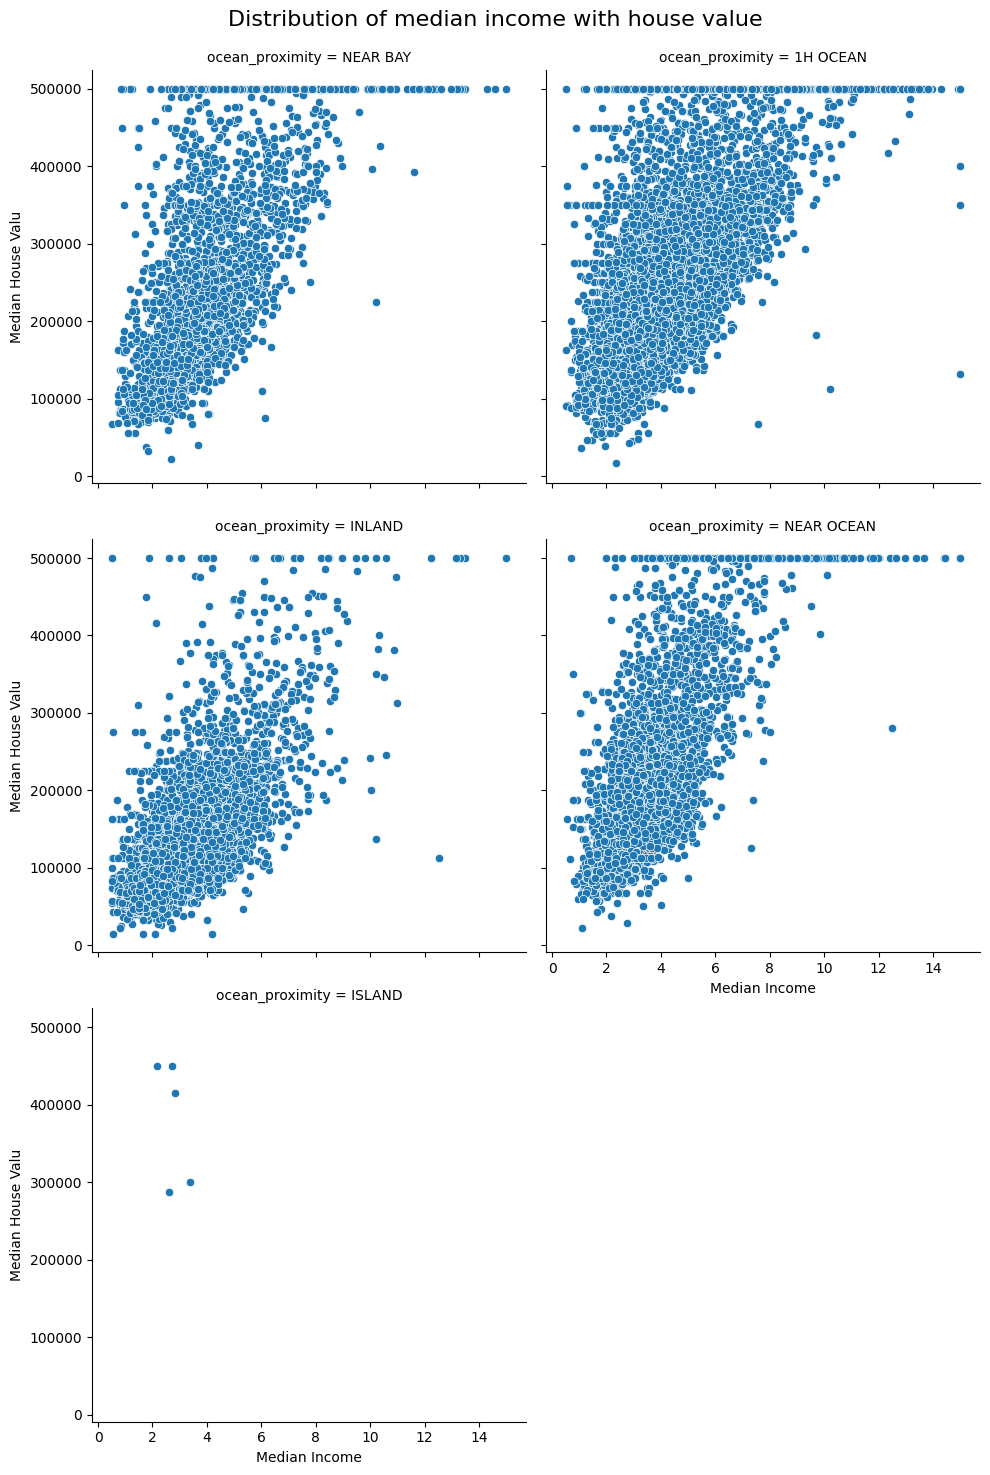

In [13]:
plt.figure(figsize=(10,6))
ax = sns.relplot(x='median_income', y='median_house_value', col='ocean_proximity',data=df_housing, kind='scatter', col_wrap=2)
ax.fig.suptitle('Distribution of median income with house value', fontsize=16)
ax.fig.subplots_adjust(top=0.94);
ax.set(xlabel='Median Income', ylabel='Median House Valu')

plt.show()

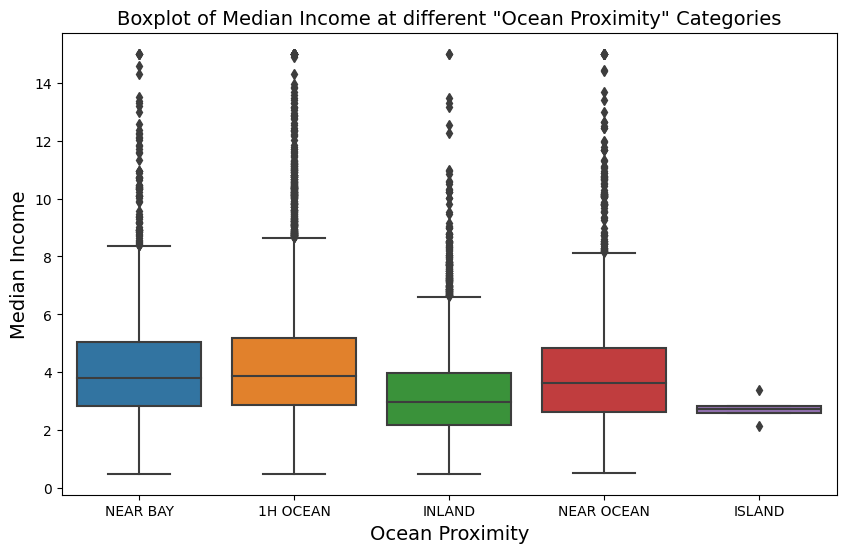

In [14]:
# check the Boxplot of (median_income) at different (ocean_proximity) values
plt.figure(figsize=(10, 6))
sns.boxplot(y='median_income', data=df_housing, x='ocean_proximity')
plt.title('Boxplot of Median Income at different "Ocean Proximity" Categories', fontsize=14, c='k')
plt.xlabel('Ocean Proximity', fontsize=14)
plt.ylabel('Median Income', fontsize=14)
plt.show()

> Here The mean is approximately the same in defferent values of ocean_proximity so this feature will not be good for us

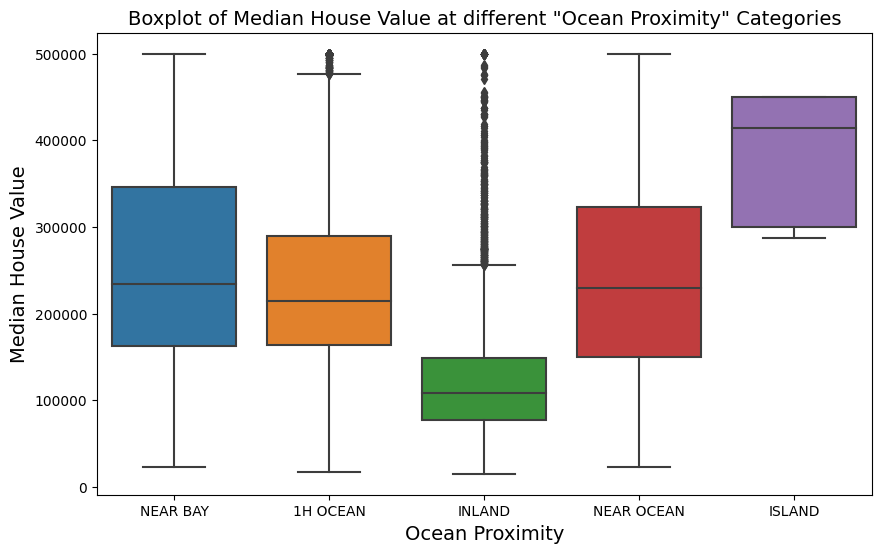

In [15]:
# check the Boxplot of (median_house_value) at different (ocean_proximity) values
plt.figure(figsize=(10, 6))
sns.boxplot(y='median_house_value', data=df_housing, x='ocean_proximity')
plt.title('Boxplot of Median House Value at different "Ocean Proximity" Categories', fontsize=14, c='k')
plt.xlabel('Ocean Proximity', fontsize=14)
plt.ylabel('Median House Value', fontsize=14)
plt.show()

### Multivariate Visualization

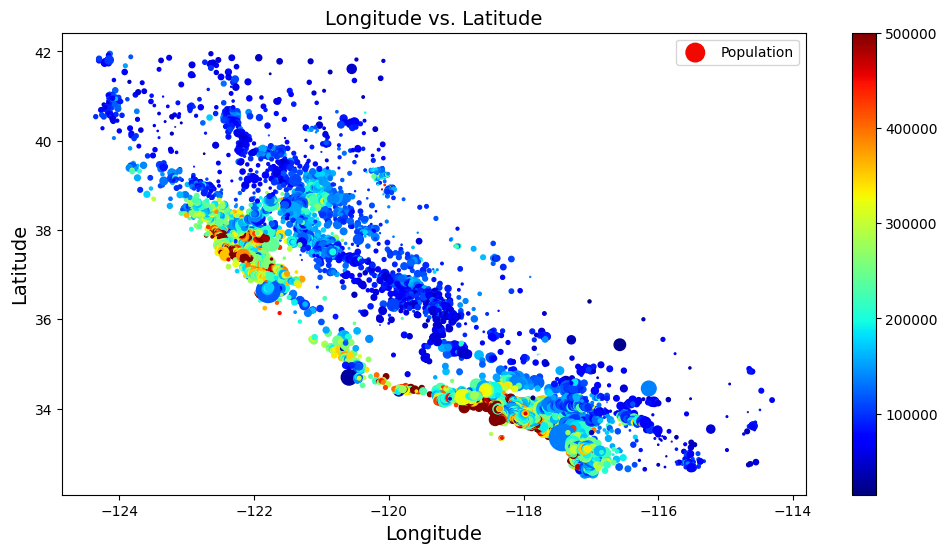

In [16]:
# Scatterplot for location, population and median_house_value

plt.figure(figsize=(12, 6))
sc = plt.scatter(x=df_housing['longitude'], y=df_housing['latitude'],
                 s=df_housing['population']/100, c=df_housing['median_house_value'],
                cmap=plt.get_cmap('jet'), label='Population')
plt.colorbar(sc)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.title('Longitude vs. Latitude', fontsize=14)
plt.legend()
plt.show()

In [17]:
import plotly.express as px

fig = px.scatter_mapbox(df_housing, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_data=["population"],
                        color="median_house_value",
                        color_continuous_scale=px.colors.sequential.Jet,
                        size=df_housing['population']/100,
 
                        zoom=4.7)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

> It looks like the prices is higher near the ocean, also these areas have higher population

## Check the Correlation between the Features and Target

In [18]:
# Check the correlation
df_housing.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

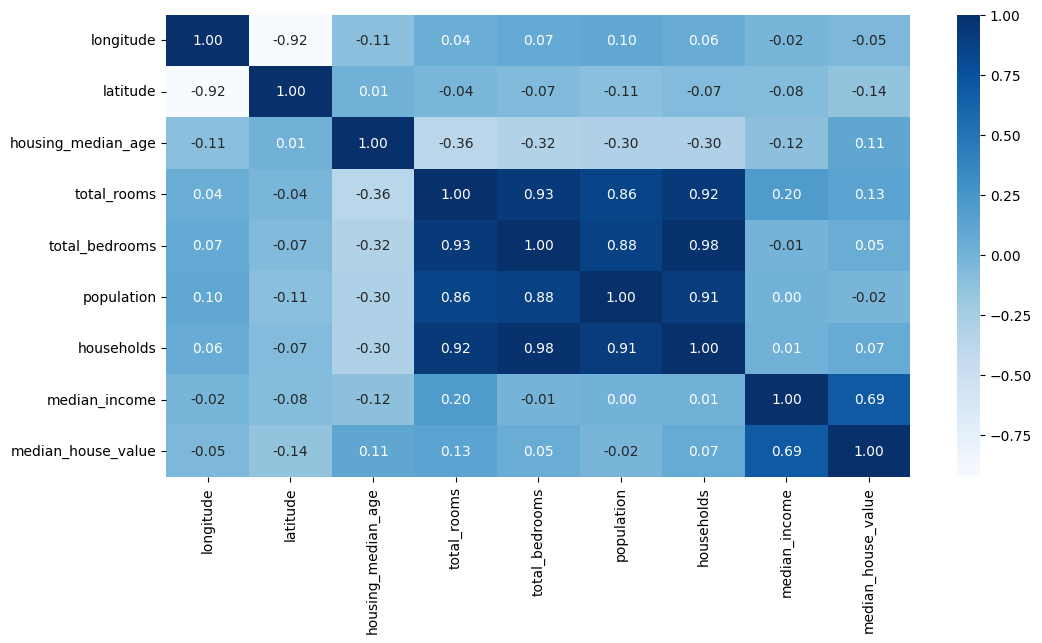

In [19]:
# Make heatmap for the correlation
plt.figure(figsize=(12,6))
sns.heatmap(df_housing.corr(numeric_only=True), annot=True, cmap='Blues', fmt='.2f')
plt.show()

In [20]:
# Making new features
df_housing['rooms_per_household'] = df_housing['total_rooms'] / df_housing['households']
df_housing['bedrooms_per_rooms'] = df_housing['total_bedrooms'] / df_housing['total_rooms']
df_housing['pioulation_per_household'] = df_housing['population'] / df_housing['households']

In [21]:
# Check the correlation
df_housing.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
pioulation_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_rooms         -0.255880
Name: median_house_value, dtype: float64

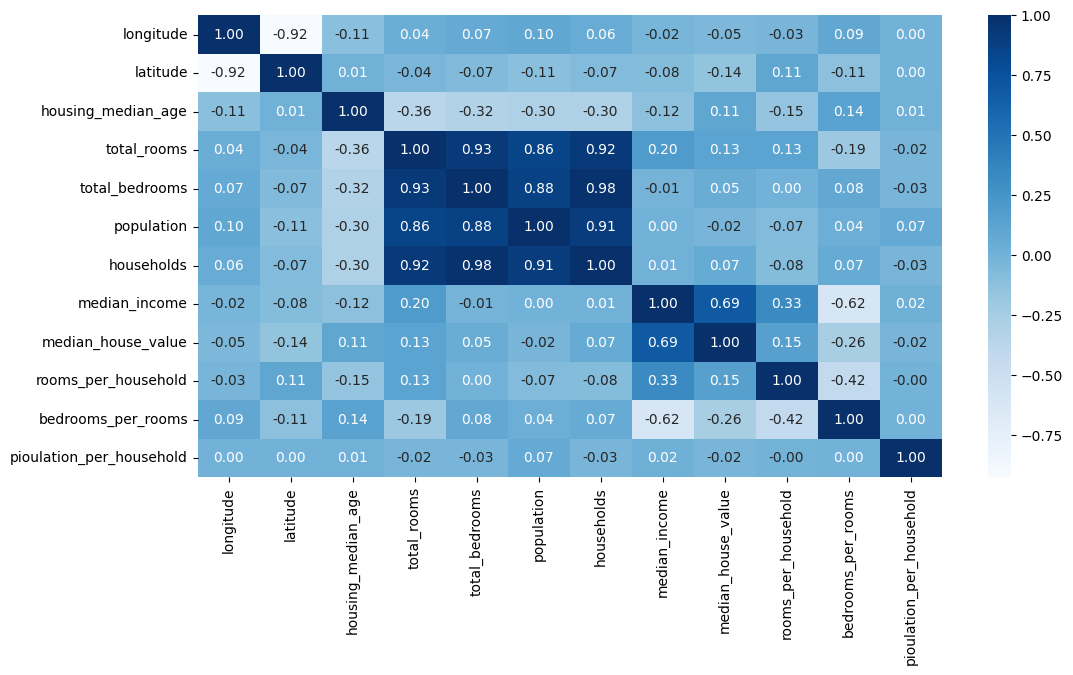

In [22]:
# Make heatmap for the correlation
plt.figure(figsize=(12,6))
sns.heatmap(df_housing.corr(numeric_only=True), annot=True, cmap='Blues', fmt='.2f')
plt.show()

> The best features are 'median_income', 'rooms_per_household', 'total_rooms', housing_median_age, 'latitude', and 'bedrooms_per_rooms'

## Split the Dataset

In [23]:
# X = features, and y = target
X = df_housing.drop(columns='median_house_value', axis=1)
y = df_housing['median_house_value']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.15, random_state=42)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (17544, 12)
y_train shape: (17544,)
X_test shape: (3096, 12)
y_test shape: (3096,)


## Data Preprocessing

### Dealing with nulls 

In [25]:
# since each data type has it's own way to deal with null values we need to know which
# columns are numerical and which are categorical

num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int32', 'int64', 'float32', 'float64']]
categ_cols = [col for col in X_train.columns if X_train[col].dtype not in ['int32', 'int64', 'float32', 'float64']]

In [26]:
# fill the numerical null values using median
imputer = SimpleImputer(strategy='median')

X_train_filled = imputer.fit_transform(X_train[num_cols])
X_test_filled = imputer.transform(X_test[num_cols])

### Standardize the Feature

In [27]:
# Standardize will help algorithm to train faster
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_filled)
X_test_scaled = scaler.transform(X_test_filled)

### Pipeline for numerical features

In [28]:
# this step will replace the Dealing with nulls, and Standardize the Feature steps
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
X_train_num = num_pipeline.fit_transform(X_train[num_cols])
X_test_num = num_pipeline.transform(X_test[num_cols])

### Pipeline for categorical features

In [29]:
# this step will replace the categorical features with numbers that reprisent this feature
categ_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('OHE', OneHotEncoder(sparse=False))
])

X_train_categ = categ_pipeline.fit_transform(X_train[categ_cols])
X_test_categ = categ_pipeline.transform(X_test[categ_cols])

### Get all Together

In [30]:
# Here we will use FeatureUnion to merge the two pipelines and apply them once

num_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(num_cols)),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categ_pipeline = Pipeline(steps=[
    ('selector', DataFrameSelector(categ_cols)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('OHE', OneHotEncoder(sparse=False))
])

total_pipeline = FeatureUnion(transformer_list=[
    ('num_pipe', num_pipeline),
    ('categ_pipe', categ_pipeline)
])

X_train_final = total_pipeline.fit_transform(X_train)
X_test_final = total_pipeline.transform(X_test)


In [31]:
print('X_train_final shape:', X_train_final.shape)
print('y_train shape:', y_train.shape)
print('X_test_final shape:', X_test_final.shape)
print('y_test shape:', y_test.shape)

X_train_final shape: (17544, 16)
y_train shape: (17544,)
X_test_final shape: (3096, 16)
y_test shape: (3096,)


## Model building

> Here we will build some models and compare between them using RMSE Metric

### 1. Linear Regression

In [32]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_final, y_train)

LinearRegression()

In [33]:
lin_reg.coef_, lin_reg.intercept_

(array([-5.61301481e+04, -5.64138107e+04,  1.38774892e+04,  6.10144119e+03,
         8.96843433e+03, -4.66337921e+04,  3.65895317e+04,  7.91759120e+04,
         6.34386857e+03,  1.65756898e+04,  7.00148408e+02,  4.17528749e+16,
         4.17528749e+16,  4.17528749e+16,  4.17528749e+16,  4.17528749e+16]),
 -4.175287490379612e+16)

In [34]:
mse_scoring_lin = cross_val_score(estimator=lin_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_lin = np.sqrt(-1 * mse_scoring_lin)
rmse_scoring_lin.mean()

67879.11645643911

In [35]:
y_pred_lin = cross_val_predict(estimator=lin_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_lin))

67897.82778423587

### 2. SGDRegressor

In [36]:
sgd_reg = SGDRegressor(penalty='l2', alpha=0.0001, shuffle=True, max_iter=10000, eta0=0.001)
sgd_reg.fit(X_train_final, y_train)

SGDRegressor(eta0=0.001, max_iter=10000)

In [37]:
mse_scoring_sgd = cross_val_score(estimator=sgd_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_sgd = np.sqrt(-1 * mse_scoring_sgd)
rmse_scoring_sgd.mean()

67995.47258547146

In [38]:
y_pred_sgd = cross_val_predict(estimator=sgd_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_sgd))

68002.57255565972

### 3. Ridge

In [39]:
ridge_reg = Ridge(alpha=0.9, solver='auto')
ridge_reg.fit(X_train_final, y_train)

Ridge(alpha=0.9)

In [40]:
mse_scoring_ridge = cross_val_score(estimator=ridge_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_ridge = np.sqrt(-1 * mse_scoring_ridge)
rmse_scoring_ridge.mean()

67880.21922984191

In [41]:
y_pred_ridge = cross_val_predict(estimator=ridge_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_ridge))

67898.94710476308

### 4. Lasso

In [42]:
lasso_reg = Lasso(alpha=1, max_iter=100000)
lasso_reg.fit(X_train_final, y_train)

Lasso(alpha=1, max_iter=100000)

In [43]:
mse_scoring_lasso = cross_val_score(estimator=lasso_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_lasso = np.sqrt(-1 * mse_scoring_lasso)
rmse_scoring_lasso.mean()

67879.9723018768

In [44]:
y_pred_lasso = cross_val_predict(estimator=lasso_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_lasso))

67898.71303825619

### 5. ElasticNet

In [45]:
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_reg.fit(X_train_final, y_train)

ElasticNet(alpha=0.1)

In [46]:
mse_scoring_elastic = cross_val_score(estimator=elastic_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_elastic = np.sqrt(-1 * mse_scoring_elastic)
rmse_scoring_elastic.mean()

68581.26101196748

In [47]:
y_pred_elastic = cross_val_predict(estimator=elastic_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_elastic))

68590.35200309506

### 6. PolynomialRegression

In [48]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_train_final)

In [49]:
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, y_train)

LinearRegression()

In [50]:
mse_scoring_poly = cross_val_score(estimator=lin_reg_poly, X=X_poly, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_poly = np.sqrt(-1 * mse_scoring_poly)
rmse_scoring_poly.mean()

3936503786071.486

In [51]:
y_pred_poly  = cross_val_predict(estimator=lin_reg_poly, X=X_poly, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_poly))

6348256308024.717

### 7. KNeighborsRegressor

In [52]:
knn_reg = KNeighborsRegressor(n_neighbors=6, weights='uniform', p=2)
knn_reg.fit(X_train_final, y_train)

KNeighborsRegressor(n_neighbors=6)

In [53]:
mse_scoring_knn = cross_val_score(estimator=knn_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_knn = np.sqrt(-1 * mse_scoring_knn)
rmse_scoring_knn.mean()

61282.180365177745

In [54]:
y_pred_knn = cross_val_predict(estimator=knn_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_knn))

61287.16400494534

### 8.RandomForestRegressor

In [55]:
forest_reg = RandomForestRegressor(n_estimators=150, max_depth=6, random_state=42, max_samples=0.8)
forest_reg.fit(X_train_final, y_train)

RandomForestRegressor(max_depth=6, max_samples=0.8, n_estimators=150,
                      random_state=42)

In [56]:
mse_scoring_forest = cross_val_score(estimator=forest_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_forest = np.sqrt(-1 * mse_scoring_forest)
rmse_scoring_forest.mean()

59969.67796450624

In [57]:
y_pred_forest = cross_val_predict(estimator=forest_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_forest))

59980.31941432441

In [58]:
parms_best_forest = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': np.arange(4, 20, 2),
    'max_samples': [0.7, 0.8, 0.9, 1]
}

search_random_forest = RandomizedSearchCV(estimator=forest_reg, param_distributions=parms_best_forest, n_iter=20, random_state=42,
                   scoring='neg_mean_squared_error', cv=5, verbose=6)

search_random_forest.fit(X_train_final, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END max_depth=18, max_samples=0.7, n_estimators=300;, score=-2387240950.516 total time=  22.4s
[CV 2/5] END max_depth=18, max_samples=0.7, n_estimators=300;, score=-2762446681.621 total time=  22.4s
[CV 3/5] END max_depth=18, max_samples=0.7, n_estimators=300;, score=-2648935103.247 total time=  22.5s
[CV 4/5] END max_depth=18, max_samples=0.7, n_estimators=300;, score=-2417353818.788 total time=  22.4s
[CV 5/5] END max_depth=18, max_samples=0.7, n_estimators=300;, score=-2538817122.387 total time=  22.3s
[CV 1/5] END max_depth=4, max_samples=0.7, n_estimators=400;, score=-4334005984.350 total time=   8.9s
[CV 2/5] END max_depth=4, max_samples=0.7, n_estimators=400;, score=-4593725450.025 total time=   8.9s
[CV 3/5] END max_depth=4, max_samples=0.7, n_estimators=400;, score=-4514789699.529 total time=   8.8s
[CV 4/5] END max_depth=4, max_samples=0.7, n_estimators=400;, score=-4340436187.570 total time=   9.3s
[CV 5/

[CV 5/5] END max_depth=8, max_samples=0.7, n_estimators=300;, score=-3163105351.405 total time=  12.2s
[CV 1/5] END max_depth=16, max_samples=0.7, n_estimators=450;, score=-2400224852.719 total time=  31.6s
[CV 2/5] END max_depth=16, max_samples=0.7, n_estimators=450;, score=-2764315256.804 total time=  31.7s
[CV 3/5] END max_depth=16, max_samples=0.7, n_estimators=450;, score=-2653233236.403 total time=  32.4s
[CV 4/5] END max_depth=16, max_samples=0.7, n_estimators=450;, score=-2423457596.285 total time=  33.4s
[CV 5/5] END max_depth=16, max_samples=0.7, n_estimators=450;, score=-2553564248.378 total time=  33.4s
[CV 1/5] END max_depth=4, max_samples=0.8, n_estimators=450;, score=-4349316458.530 total time=  11.6s
[CV 2/5] END max_depth=4, max_samples=0.8, n_estimators=450;, score=-4609289274.238 total time=  11.6s
[CV 3/5] END max_depth=4, max_samples=0.8, n_estimators=450;, score=-4537898367.163 total time=  12.6s
[CV 4/5] END max_depth=4, max_samples=0.8, n_estimators=450;, score=

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=6, max_samples=0.8,
                                                   n_estimators=150,
                                                   random_state=42),
                   n_iter=20,
                   param_distributions={'max_depth': array([ 4,  6,  8, 10, 12, 14, 16, 18]),
                                        'max_samples': [0.7, 0.8, 0.9, 1],
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=6)

In [59]:
search_random_forest.best_params_

{'n_estimators': 200, 'max_samples': 0.9, 'max_depth': 18}

In [60]:
best_forest = search_random_forest.best_estimator_

In [61]:
mse_scoring_best_forest = cross_val_score(estimator=best_forest, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_best_forest = np.sqrt(-1 * mse_scoring_best_forest)
rmse_scoring_best_forest.mean()

50325.71803874934

In [62]:
y_pred_best_forest = cross_val_predict(estimator=best_forest, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_best_forest))

50348.11212500596

#### Feature Importance using RF

In [63]:
feat_import_forest = {}
for name, score in zip(num_cols, best_forest.feature_importances_[:11]):
  feat_import_forest[name] = score

In [64]:
keys_forest = feat_import_forest.keys()
value_forest = feat_import_forest.values()

In [65]:
df_feat_import_forest = pd.DataFrame({'Features': keys_forest, 'Scores': value_forest})
df_feat_import_forest.sort_values(by='Scores', ascending=False, inplace=True)
df_feat_import_forest

Features    Scores
7              median_income  0.480359
10  pioulation_per_household  0.122523
0                  longitude  0.056506
1                   latitude  0.055941
2         housing_median_age  0.043663
8        rooms_per_household  0.025361
9         bedrooms_per_rooms  0.023948
3                total_rooms  0.012460
4             total_bedrooms  0.011364
5                 population  0.011165
6                 households  0.010049

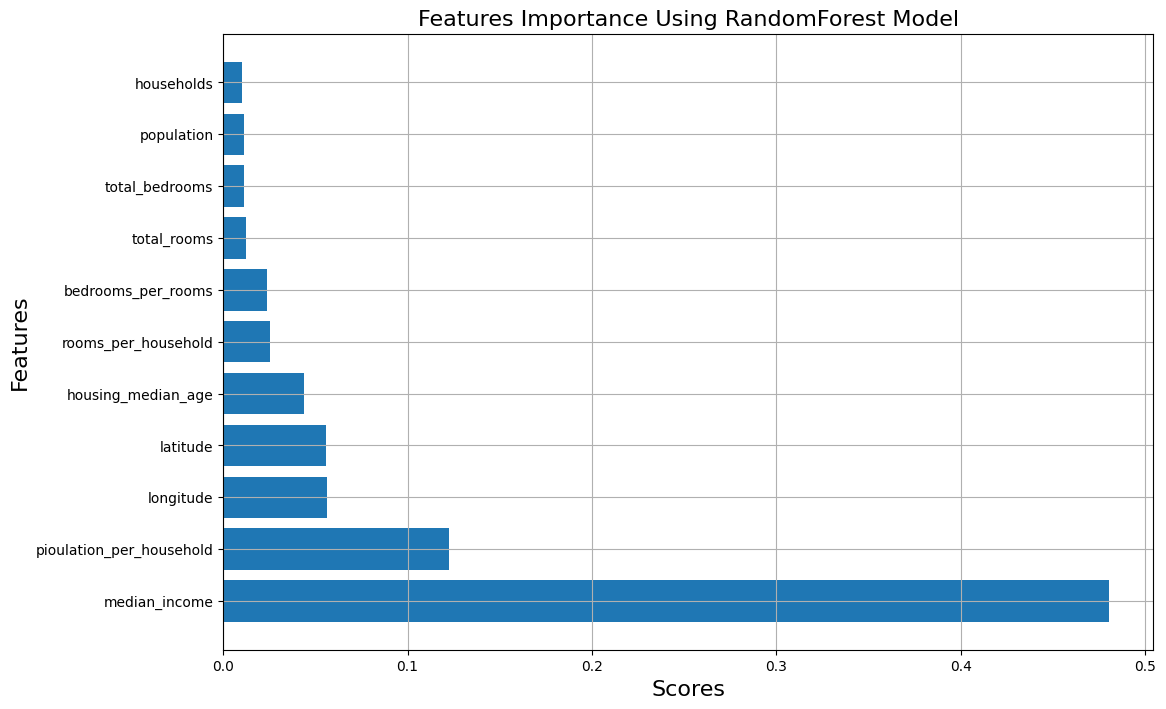

In [66]:
plt.figure(figsize=(12, 8))
plt.barh(y=df_feat_import_forest['Features'], width=df_feat_import_forest['Scores'])
plt.title('Features Importance Using RandomForest Model', fontsize=16)
plt.xlabel('Scores', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.grid('on')

### 9. XGBRegressor

In [67]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8)
xgb_reg.fit(X_train_final, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [68]:
mse_scoring_XGB = cross_val_score(estimator=xgb_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_XGB = np.sqrt(-1 * mse_scoring_XGB)
rmse_scoring_XGB.mean()

47577.55050470175

In [69]:
y_pred_XGB = cross_val_predict(estimator=xgb_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_XGB))

47588.59197774307

In [70]:
params_best_XGB = {
    'n_estimators': np.arange(100, 200, 50),
    'max_depth': np.arange(4, 15, 2),
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 0.9]
}

grid_xgb = GridSearchCV(estimator=xgb_reg, param_grid=params_best_XGB, cv=5,
                        n_jobs=-1, verbose=6, scoring='neg_mean_squared_error')

grid_xgb.fit(X_train_final, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=0, gpu_id=-1,
                                    grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.1, max_bin=...
                                    max_delta_step=0, max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=0, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2],
                         'max_depth': array([ 4,  6,  8, 10, 12, 14]),
                         'n_estimators': array([100, 150]),
                         'subsample': [0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=6)

In [71]:
grid_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.8}

In [72]:
best_xgb = grid_xgb.best_estimator_

In [73]:
mse_scoring_best_xgb = cross_val_score(estimator=best_xgb, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_best_xgb = np.sqrt(-1 * mse_scoring_best_xgb)
rmse_scoring_best_xgb.mean()

45876.564155415916

In [74]:
y_pred_best_xgb = cross_val_predict(estimator=best_xgb, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_best_xgb))

45884.94811111908

#### Feature Importance using XGBoost

In [75]:
feat_import_xgb = best_xgb.get_booster().get_score(importance_type='weight')
df_feat_import_xgb = pd.DataFrame.from_dict(feat_import_xgb, orient='index')
df_feat_import_xgb = df_feat_import_xgb.reset_index()
df_feat_import_xgb = df_feat_import_xgb.rename(columns={'index': 'Features', 0:'Scores'})

scores_sum = df_feat_import_xgb['Scores'].sum()
df_feat_import_xgb['Scores'] = df_feat_import_xgb['Scores'] / scores_sum
df_feat_import_xgb = df_feat_import_xgb[:11]
df_feat_import_xgb['Features'] = num_cols
df_feat_import_xgb = df_feat_import_xgb.sort_values(by='Scores', ascending=False)

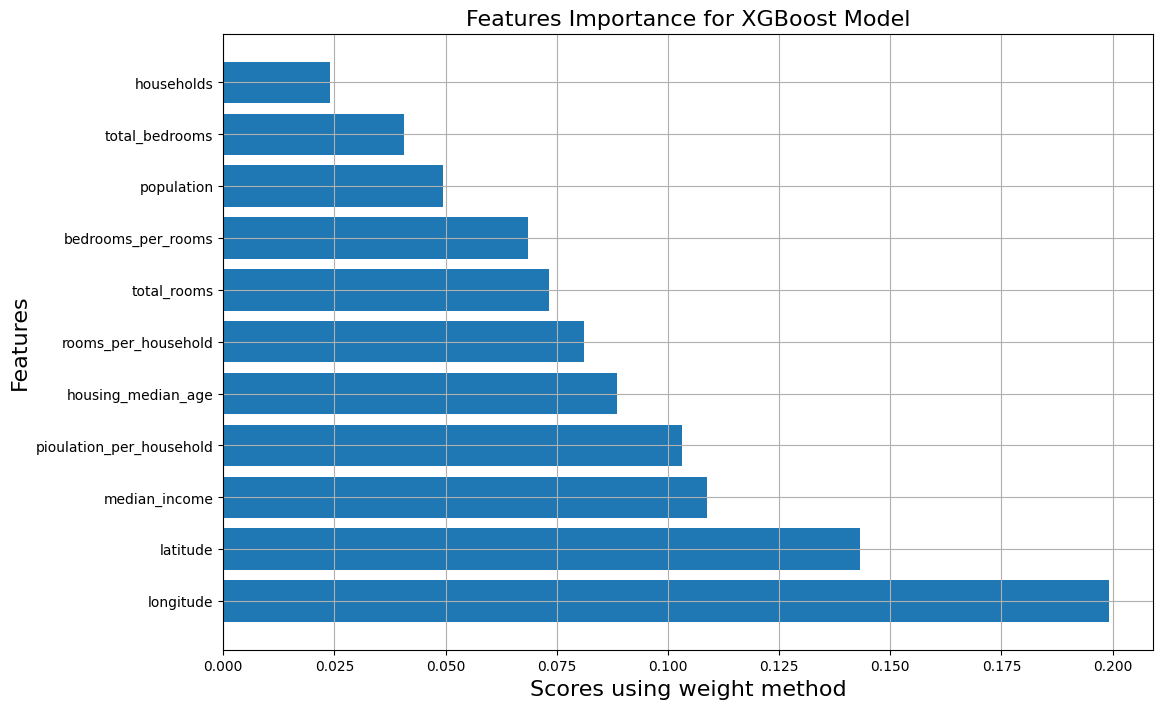

In [76]:
plt.figure(figsize=(12, 8))
plt.barh(y=df_feat_import_xgb['Features'], width=df_feat_import_xgb['Scores'])
plt.title('Features Importance for XGBoost Model', fontsize=16)
plt.xlabel('Scores using weight method', fontsize=16)
plt.ylabel('Features', fontsize=16)
plt.grid('on')
plt.show()

### 10. VotingRegressor

In [77]:
voting_reg = VotingRegressor(estimators=[
    ('tuned_forest', best_forest),
    ('tuned_xgb', best_xgb)
])

voting_reg.fit(X_train_final, y_train)

VotingRegressor(estimators=[('tuned_forest',
                             RandomForestRegressor(max_depth=18,
                                                   max_samples=0.9,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('tuned_xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.1, max_bin=256,
                                          max_cat_threshold=64,
                                          max_cat_to_onehot=4, max_delta_step=0,
                                          max_depth=8, max_leaves=0,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=150, n_jobs=0,
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=0, ...))])

In [78]:
mse_scoring_voting = cross_val_score(estimator=voting_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rmse_scoring_best_voting= np.sqrt(-1 * mse_scoring_voting)
rmse_scoring_best_voting.mean()

47150.65699848691

In [79]:
y_pred_voting = cross_val_predict(estimator=voting_reg, X=X_train_final, y=y_train, cv=5, n_jobs=-1, method='predict')
np.sqrt(mean_squared_error(y_train, y_pred_voting))

47165.08511183608

## Models Comparison

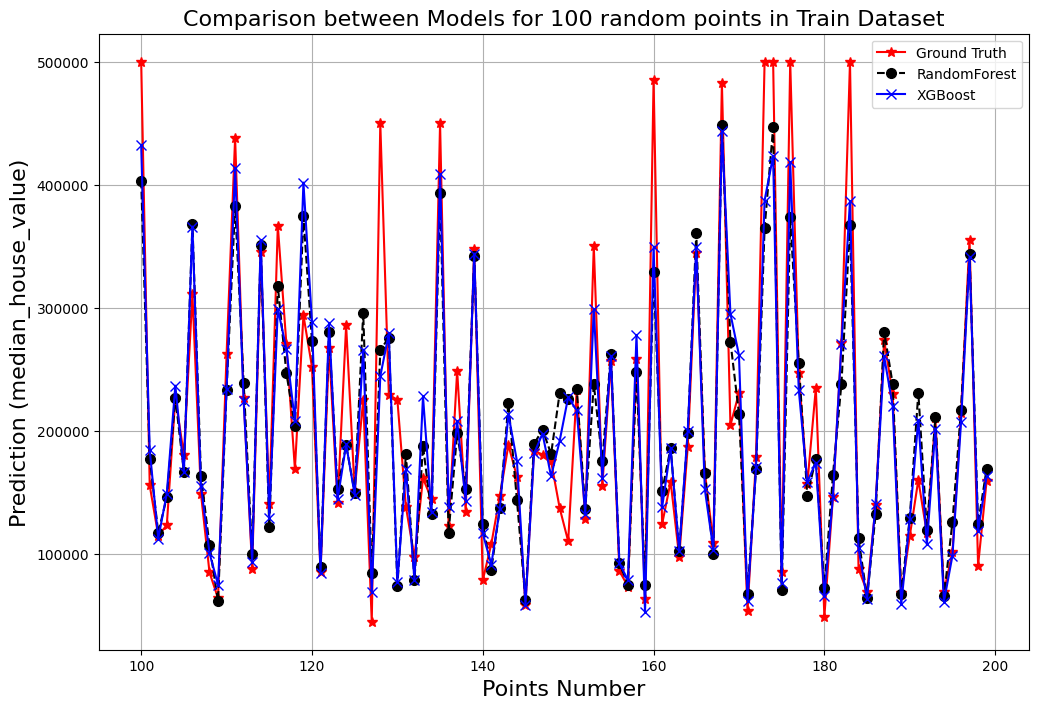

In [80]:
x_x = np.arange(100, 200)

plt.figure(figsize=(12, 8))
plt.plot(x_x, y_train.values[100:200], 'r*-',  markersize=7, label='Ground Truth')
plt.plot(x_x, y_pred_best_forest[100:200], 'ko--', markersize=7, label='RandomForest')
plt.plot(x_x, y_pred_best_xgb[100:200], 'bx-', markersize=7, label='XGBoost')
plt.title('Comparison between Models for 100 random points in Train Dataset', fontsize=16)
plt.xlabel('Points Number', fontsize=16)
plt.ylabel('Prediction (median_house_value)', fontsize=16)
plt.legend()
plt.grid('on')
plt.show()

## Save the best model (in this case best_xgb)

In [81]:
joblib.dump(best_xgb, 'model_XGBoost.pkl')

['model_XGBoost.pkl']

### Test the saved model

In [82]:
loaded_model = joblib.load('model_XGBoost.pkl')
loaded_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [83]:
y_pred_test = loaded_model.predict(X_test_final)
np.sqrt(mean_squared_error(y_test, y_pred_test))

44640.304206671775